In [ ]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow_model_optimization as tfmot
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
pip install -q tensorflow-model-optimization

In [ ]:
##get the data and the net information from Google Drive
from google.colab import drive
drive.mount('/content/drive')
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.


In [ ]:
##data loader and the preprocess
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

In [ ]:
clean_data_filename = str('/content/drive/MyDrive/lab3/test.h5')
test_data_filename = str('/content/drive/MyDrive/lab3/valid.h5')
train_images, train_labels=data_loader(clean_data_filename)
train_images=data_preprocess(train_images)
##print("Shape of train_images: {0}".format(train_images.shape))
##print("Shape of train_labels: {0}".format(train_labels.shape))

tune_images, tune_labels=data_loader(clean_data_filename)
tune_images=data_preprocess(tune_images)

##define the parameter for pruning

prune_low_magnitude=tfmot.sparsity.keras.prune_low_magnitude
batch_size = 128
epochs_test = np.array([2, 4, 6, 8, 10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56])
validation_split = 0.1

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.8, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

#dense layers train with pruning
def apply_pruning_to_dense(layer):
  if layer.name in ['conv_3']:
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

In [ ]:
K.clear_session()

In [ ]:
##load in the Badnet
model_filename = str('/content/drive/MyDrive/lab3_data/bd_net.h5')
bd_model = keras.models.load_model(model_filename)
##bd_model.summary()

In [ ]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
##model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [ ]:
sunglasses_data_filename = str('/content/drive/MyDrive/lab3/bd_valid.h5')

In [ ]:
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(sunglasses_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  #print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epochs=2 (clean data) - pruned test accuracy: 0.9305447340011597
Epochs=4 (clean data) - pruned test accuracy: 0.9359140992164612
Epochs=6 (clean data) - pruned test accuracy: 0.9479518532752991
Epochs=8 (clean data) - pruned test accuracy: 0.9487312436103821
Epochs=10 (clean data) - pruned test accuracy: 0.9506365060806274
Epochs=12 (clean data) - pruned test accuracy: 0.9511561393737793
Epochs=14 (clean data) - pruned test accuracy: 0.9508963227272034
Epochs=16 (clean data) - pruned test accuracy: 0.9513293504714966
Epochs=18 (clean data) - pruned test accuracy: 0.9508097171783447
Epochs=20 (clean data) - pruned test accuracy: 0.950982928276062


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean Classification accuracy over pruned channels')
plt.grid()
plt.xlabel('Prune channels')
plt.ylabel('Clean Classifiation accuracy')

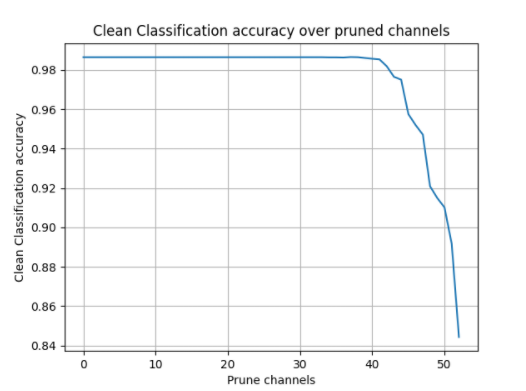

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_test, posion_accuracy)
plt.title('Attack Success Rate over pruned channels')
plt.grid()
plt.xlabel('Prune channels')
plt.ylabel('asr')

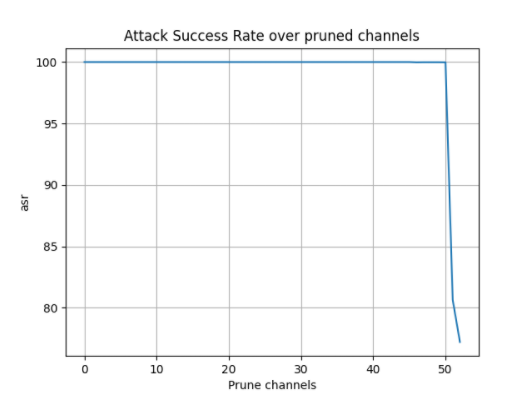

Questions Answer:
For the attack sucess is reduced to very low(about 50%) when the X=30%,I think this  pruning defense works for this model, since with the number of epoches incrasing,the asr could be reduced under very low level.